```mermaid
flowchart LR

classDef notebook fill:#5c7fa6,stroke:#3f5a7b,color:#f2f6fb, font-weight:bold;
classDef python fill:#9a80b8,stroke:#6d5789,color:#f7f3fb, font-weight:bold;
classDef tools fill:#e9c48a,stroke:#b58950,color:#2d1c05;
classDef methods fill:#8cc7ab,stroke:#5e9475,color:#0f2f1f;

N05B["05_composites.ipynb"]:::notebook

N05B --> C1["composite_generator.py"]:::python

C1 --> T6["Tools:<br>polars (optional)<br>numpy<br>Pillow<br>os<br>random"]:::tools

T6 --> M6["Methods:<br>filter_images()<br>make_composite()<br>filter_faces()<br>generate_composite()"]:::methods


In [1]:
import os, sys
from pathlib import Path

# Ensure cwd is project root for imports/paths
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
os.chdir(PROJECT_ROOT)

SRC_PATH = PROJECT_ROOT / "src"
if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))

print("cwd:", Path.cwd())
print("src path added:", SRC_PATH)


cwd: /Users/jayklarin/__DI/Repositories/FaceStats
src path added: /Users/jayklarin/__DI/Repositories/FaceStats/src


### Step 7 — Composite Generation (FaceStats V4)

This step generates composite (mean) faces filtered by:

- age range  
- gender  
- ethnicity  
- attractiveness score range  
- sample size N  
- random vs top-N selection  

Uses:  
`src/composite/composite_generator.py`  

In [2]:
import polars as pl
from composite.composite_generator import filter_images, make_composite

# Base metadata
df_attr = pl.read_parquet('data/processed/metadata/attributes_clean.parquet')
df_score = pl.read_parquet('data/processed/metadata/attractiveness_scores.parquet')
df = df_attr.join(df_score, on='filename', how='left')

# Optional geometry-based attractiveness from FaceMesh
try:
    df_meta = pl.read_parquet('data/processed/metadata/attributes_with_meta.parquet')
    if 'attractiveness_geom' in df_meta.columns:
        df = df.join(df_meta.select(['filename','attractiveness_geom']), on='filename', how='left')
except FileNotFoundError:
    pass

print(df.head())
print('Columns:', df.columns)


shape: (5, 6)
┌────────────────────┬──────┬──────────────┬─────────────────┬────────────────┬────────────────────┐
│ filename           ┆ age  ┆ gender_final ┆ ethnicity_final ┆ attractiveness ┆ attractiveness_geo │
│ ---                ┆ ---  ┆ ---          ┆ ---             ┆ ---            ┆ m                  │
│ str                ┆ null ┆ str          ┆ str             ┆ f32            ┆ ---                │
│                    ┆      ┆              ┆                 ┆                ┆ i64                │
╞════════════════════╪══════╪══════════════╪═════════════════╪════════════════╪════════════════════╡
│ SFHQ_pt4_00000001. ┆ null ┆ unknown      ┆ unknown         ┆ null           ┆ 1                  │
│ jpg                ┆      ┆              ┆                 ┆                ┆                    │
│ SFHQ_pt4_00000002. ┆ null ┆ unknown      ┆ unknown         ┆ null           ┆ 9                  │
│ jpg                ┆      ┆              ┆                 ┆               

### Step 7A — Filter Images for Composite

Adjust parameters:
- age_min, age_max  
- gender  
- ethnicity  
- score_min, score_max  
- sample size N  


In [3]:
# Adjust filters here
gender = 'female'
ethnicity = None
age_range = None
score_range = None  # tuple like (min, max) on attractiveness scores if desired
geom_range = None   # tuple like (min, max) on attractiveness_geom 1–10

# Base filter via helper
df_filt = filter_images(
    df=df,
    gender=gender,
    ethnicity=ethnicity,
    age_range=age_range,
    attractiveness=score_range,
)

# Optional geometry filter
if geom_range and 'attractiveness_geom' in df_filt.columns:
    lo, hi = geom_range
    df_filt = df_filt.filter((pl.col('attractiveness_geom') >= lo) & (pl.col('attractiveness_geom') <= hi))

print(df_filt.head())
print(df_filt.shape)


shape: (5, 6)
┌────────────────────┬──────┬──────────────┬─────────────────┬────────────────┬────────────────────┐
│ filename           ┆ age  ┆ gender_final ┆ ethnicity_final ┆ attractiveness ┆ attractiveness_geo │
│ ---                ┆ ---  ┆ ---          ┆ ---             ┆ ---            ┆ m                  │
│ str                ┆ str  ┆ str          ┆ str             ┆ f32            ┆ ---                │
│                    ┆      ┆              ┆                 ┆                ┆ f64                │
╞════════════════════╪══════╪══════════════╪═════════════════╪════════════════╪════════════════════╡
│ SFHQ_pt4_00000022. ┆ null ┆ female       ┆ white           ┆ null           ┆ 9.0                │
│ jpg                ┆      ┆              ┆                 ┆                ┆                    │
│ SFHQ_pt4_00000023. ┆ null ┆ female       ┆ white           ┆ 3.337421       ┆ 5.0                │
│ jpg                ┆      ┆              ┆                 ┆               

### Step 7B — Generate Composite

Set:
- n = number of images to use
- random_sample = True/False  
- outname = filename of output composite


Using 25 images


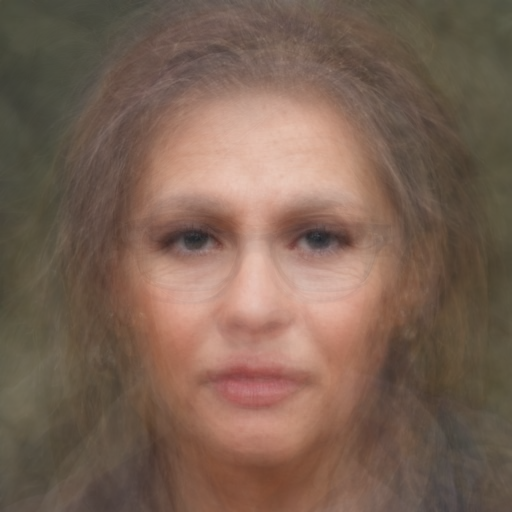

In [4]:
# Select filenames for the composite (captured for display)
n = 25
random_sample = False

filenames = df_filt["filename"].to_list()
if not filenames:
    raise ValueError("No images matched the filter criteria.")

if n is not None:
    if random_sample:
        import random
        random.seed(42)
        filenames = random.sample(filenames, min(n, len(filenames)))
    else:
        filenames = filenames[:n]

df_sel = df_filt.filter(pl.col("filename").is_in(filenames))
print(f"Using {len(filenames)} images")

out = make_composite(
    df_sel,
    n=None,                # already selected filenames
    random_sample=False,
    outname="composite_v4_example.jpg"
)

out


### Step 7C — Display the Generated Composite

In [5]:
# from PIL import Image

# if out:
#     display(Image.open(out))
# else:
#     print("No composite generated.")


### Step 7D — Source Portraits (scaled, 5×5 max)
Displays the portraits used to build the composite.

In [6]:
# import matplotlib.pyplot as plt
# import numpy as np
# from pathlib import Path
# from PIL import Image

# if not filenames:
#     raise ValueError("No filenames selected; run the composite cell first.")

# preproc_dir = Path("data/processed/preproc")
# num = len(filenames)
# grid = int(np.ceil(np.sqrt(max(num, 1))))
# fig, axes = plt.subplots(grid, grid, figsize=(grid * 2, grid * 2))
# axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]

# for ax, fname in zip(axes, filenames):
#     img_path = preproc_dir / fname
#     try:
#         img = Image.open(img_path).convert("RGB").resize((96, 96))
#         ax.imshow(img)
#         ax.set_title(Path(fname).stem, fontsize=6)
#     except Exception as e:
#         ax.text(0.5, 0.5, f"missing\n{fname}", ha='center', va='center', fontsize=6)
#     ax.axis('off')

# for ax in axes[num:]:
#     ax.axis('off')

# plt.tight_layout()
# plt.show()


### Step 7E — Composite + Sources Side by Side

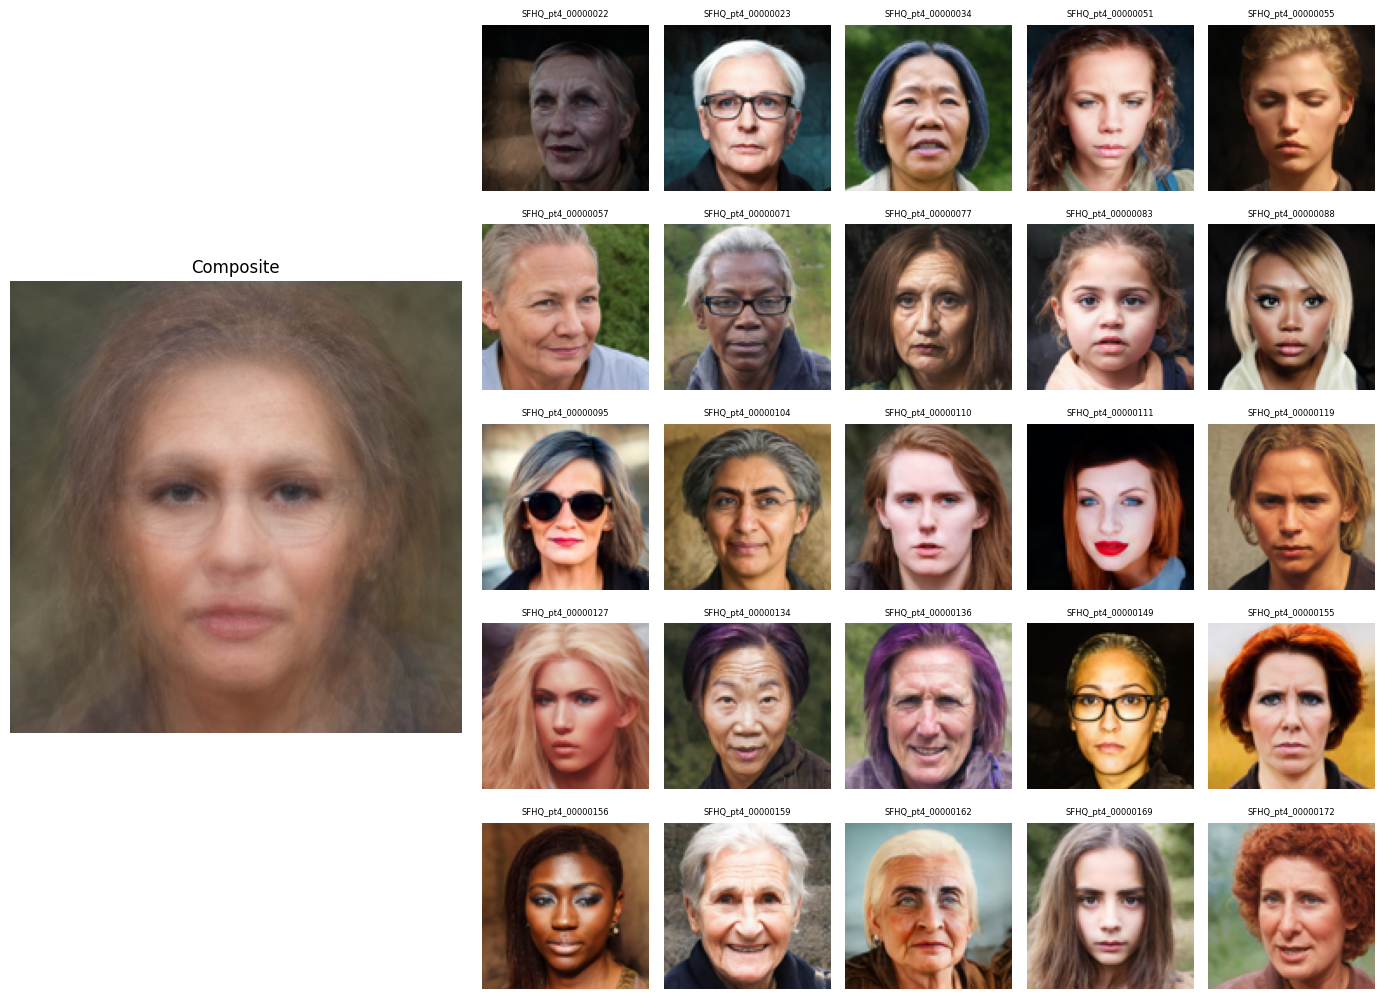

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from PIL import Image

if not out:
    raise ValueError("No composite available; run the composite cell first.")
if not filenames:
    raise ValueError("No filenames captured; run the selection cell first.")

composite_img = out
preproc_dir = Path("data/processed/preproc")
num = len(filenames)
grid = int(np.ceil(np.sqrt(max(num, 1))))

fig = plt.figure(figsize=(grid * 2 + 4, grid * 2))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 2])

ax_comp = fig.add_subplot(gs[0, 0])
ax_comp.imshow(composite_img)
ax_comp.set_title("Composite")
ax_comp.axis("off")

subgs = gs[0, 1].subgridspec(grid, grid)
axes = [fig.add_subplot(subgs[i, j]) for i in range(grid) for j in range(grid)]

for ax, fname in zip(axes, filenames):
    img_path = preproc_dir / fname
    try:
        img = Image.open(img_path).convert("RGB").resize((96, 96))
        ax.imshow(img)
        ax.set_title(Path(fname).stem, fontsize=6)
    except Exception as e:
        ax.text(0.5, 0.5, f"missing\n{fname}", ha='center', va='center', fontsize=6)
    ax.axis('off')

for ax in axes[num:]:
    ax.axis('off')

plt.tight_layout()
plt.show()
